# Physics-Informed Neural Networks for PDEs
## Solving the 1D Heat Equation Without Discretization

**Physics-Informed Neural Networks (PINNs)** train neural networks to satisfy both governing equations
and boundary/initial conditions simultaneously—no spatial or temporal discretization required.

| Traditional PDE Methods | PINNs |
|------------------------|-------|
| Require spatial mesh | **Meshfree**: continuous solution everywhere |
| Fixed grid resolution | **Adaptive**: query at any $(x,t)$ |
| Discrete solutions | **Differentiable**: embed in optimization pipelines |
| Struggle with sparse data | **Data-efficient**: fuse physics with observations |

---

## The Physical System

The 1D heat equation models thermal diffusion:

$$\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$$

**Notation:**
- $u(x,t)$ = temperature at position $x$ and time $t$
- $\alpha$ = thermal diffusivity (controls diffusion rate, units: m²/s)

**Physical Interpretation:** Heat flows from hot regions to cold regions, with rate proportional to the second spatial derivative (curvature). High curvature means rapid temperature change.

---

## Problem Setup

**Domain:** $x \in [0, 1]$, $t \in [0, T]$

**Initial Condition (IC):**

$$u(x, 0) = \sin(\pi x)$$

Initial temperature distribution is a half sine wave—hot in the middle, cool at edges.

**Boundary Conditions (BC):**

$$u(0, t) = 0, \quad u(1, t) = 0$$

Both endpoints are held at zero temperature (Dirichlet boundary conditions).

**Analytical Solution:** For this specific problem, the exact solution is known:

$$u(x,t) = \sin(\pi x) e^{-\pi^2 \alpha t}$$

This allows us to validate PINN accuracy against ground truth—the spatial profile decays exponentially in time.

**Navigation:** [Jump to Control Panel](#control-panel)

In [ ]:
import marimo as mo
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

---
## 1. The PINN Formulation

### Core Idea

Approximate $u(x,t)$ with neural network $u_\phi(x,t)$ by minimizing:

$$\mathcal{L}_{\text{total}} = w_{\text{PDE}} \mathcal{L}_{\text{PDE}} + w_{\text{IC}} \mathcal{L}_{\text{IC}} + w_{\text{BC}} \mathcal{L}_{\text{BC}}$$

where derivatives are computed via **automatic differentiation**.

### 1.1 Physics Residual

The governing equation enforces energy conservation at **collocation points** $\{(x_i, t_i)\}$:

$$\mathcal{R}_{\text{PDE}}(x, t) = \frac{\partial u}{\partial t} - \alpha \frac{\partial^2 u}{\partial x^2} = 0$$

**Physics Loss:**

$$\mathcal{L}_{\text{PDE}} = \frac{1}{N_c}\sum_{i=1}^{N_c} \left[\frac{\partial u}{\partial t}(x_i, t_i) - \alpha \frac{\partial^2 u}{\partial x^2}(x_i, t_i)\right]^2$$

### 1.2 Initial Condition

Temperature distribution at $t=0$:

$$\mathcal{L}_{\text{IC}} = \frac{1}{N_{\text{IC}}}\sum_{i=1}^{N_{\text{IC}}} |u(x_i, 0) - \sin(\pi x_i)|^2$$

### 1.3 Boundary Conditions

Fixed temperature at boundaries (Dirichlet BCs):

$$\mathcal{L}_{\text{BC}} = \frac{1}{N_{\text{BC}}}\sum_{i=1}^{N_{\text{BC}}} \left[|u(0, t_i)|^2 + |u(1, t_i)|^2\right]$$

### Why Multiple Loss Terms?

- **PDE loss**: Ensures physics is satisfied throughout the domain
- **IC loss**: Matches initial temperature profile
- **BC loss**: Enforces boundary temperature constraints
- **Weights** $w_{\text{PDE}}, w_{\text{IC}}, w_{\text{BC}}$: Balance competing objectives

In [ ]:
def u_initial(x):
    """Initial condition: u(x, 0) = sin(pi*x)"""
    return np.sin(np.pi * x)

def u_analytical(x, t, alpha):
    """Analytical solution: u(x,t) = sin(pi*x) * exp(-pi^2 * alpha * t)"""
    return np.sin(np.pi * x) * np.exp(-np.pi**2 * alpha * t)

### 2. Neural Network Architecture

A configurable feedforward network (tunable hidden layers and width, tanh activations) maps $(x, t)$ to temperature $u(x,t)$.

**Input dimension:** 2 (position $x$ and time $t$)

**Output dimension:** 1 (temperature $u$)

In [ ]:
class PINN(nn.Module):
    """Physics-Informed Neural Network for 1D Heat Equation

    Architecture:
    - Input: (x, t) ∈ R²
    - Configurable hidden layers with adjustable width
    - Tanh activation functions
    - Output: u(x,t) ∈ R
    """
    def __init__(self, width=32, num_layers=3):
        super(PINN, self).__init__()
        layers = []
        layers.append(nn.Linear(2, width))  # 2 inputs: x and t
        layers.append(nn.Tanh())

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(width, 1))  # 1 output: u
        self.net = nn.Sequential(*layers)

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        return self.net(inputs)

### 2.2 PDE Residual Computation via Automatic Differentiation

PyTorch's `torch.autograd.grad` computes derivatives of the network output with respect to inputs.

**Key steps:**

1. **First-order derivatives**: Compute $\frac{\partial u}{\partial x}$ and $\frac{\partial u}{\partial t}$ using `torch.autograd.grad` with `create_graph=True`
2. **Second-order derivative**: Compute $\frac{\partial^2 u}{\partial x^2}$ by differentiating $\frac{\partial u}{\partial x}$ again
3. **Residual**: Combine as $\mathcal{R} = u_t - \alpha u_{xx}$

**Why `create_graph=True`?** Enables higher-order derivatives by keeping the computational graph for backpropagation through the gradient computation itself.

In [ ]:
def pde_residual(pinn_model, x, t, alpha):
    """Compute the PDE residual for the heat equation

    Residual = u_t - alpha * u_xx

    Uses automatic differentiation to compute:
    - u_t: first derivative w.r.t. time
    - u_x: first derivative w.r.t. space
    - u_xx: second derivative w.r.t. space
    """
    # Predict the solution u(x, t)
    u = pinn_model(x, t)

    # Compute partial derivatives using autograd
    # First derivatives
    u_x = torch.autograd.grad(
        u, x, torch.ones_like(u), create_graph=True, retain_graph=True
    )[0]
    u_t = torch.autograd.grad(
        u, t, torch.ones_like(u), create_graph=True, retain_graph=True
    )[0]

    # Second spatial derivative
    u_xx = torch.autograd.grad(
        u_x, x, torch.ones_like(u_x), create_graph=True, retain_graph=True
    )[0]

    # Calculate the PDE residual: u_t - alpha * u_xx
    pde_res = u_t - alpha * u_xx
    return pde_res

### 2.3 Training Loop

In [ ]:
@mo.persistent_cache
def train_model(
    x_min,
    x_max,
    t_min,
    t_max,
    alpha,
    n_collocation,
    n_ic,
    n_bc,
    epochs,
    lr,
    pde_weight,
    ic_weight,
    bc_weight,
    hidden_width,
    num_layers,
    print_every,
    device_type,
):
    """Train PINN for 1D heat equation

    All UI parameters are function arguments for persistent caching.
    Returns dict with model, training history, and test predictions.
    """
    import torch
    import torch.nn as nn

    # Import network and residual from outer scope
    from __main__ import PINN, pde_residual, u_initial

    device = torch.device(device_type)

    # Generate collocation points (for PDE residual)
    x_collocation = torch.rand(n_collocation, 1, device=device) * (x_max - x_min) + x_min
    t_collocation = torch.rand(n_collocation, 1, device=device) * (t_max - t_min) + t_min
    collocation_points = torch.cat([x_collocation, t_collocation], dim=1)
    collocation_points.requires_grad = True

    # Generate initial condition points (IC)
    x_ic = torch.rand(n_ic, 1, device=device) * (x_max - x_min) + x_min
    t_ic = torch.zeros(n_ic, 1, device=device)
    ic_points = torch.cat([x_ic, t_ic], dim=1)
    u_ic = torch.tensor(u_initial(x_ic.cpu().detach().numpy()), dtype=torch.float32, device=device)

    # Generate boundary condition points (BC)
    t_bc = torch.rand(n_bc, 1, device=device) * (t_max - t_min) + t_min
    x_bc_left = torch.full((n_bc, 1), x_min, device=device)
    x_bc_right = torch.full((n_bc, 1), x_max, device=device)
    bc_points_left = torch.cat([x_bc_left, t_bc], dim=1)
    bc_points_right = torch.cat([x_bc_right, t_bc], dim=1)

    # Initialize model
    pinn = PINN(width=hidden_width, num_layers=num_layers).to(device)
    optimizer = torch.optim.Adam(pinn.parameters(), lr=lr)
    loss_function = nn.MSELoss()

    # Training loop
    losses = {
        'total': [],
        'pde': [],
        'ic': [],
        'bc': []
    }

    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()

        # PDE Loss
        pde_res = pde_residual(
            pinn,
            collocation_points[:, 0:1],
            collocation_points[:, 1:2],
            alpha
        )
        pde_loss = loss_function(pde_res, torch.zeros_like(pde_res))

        # IC Loss
        u_ic_pred = pinn(ic_points[:, 0:1], ic_points[:, 1:2])
        ic_loss = loss_function(u_ic_pred, u_ic)

        # BC Loss
        u_bc_pred_left = pinn(bc_points_left[:, 0:1], bc_points_left[:, 1:2])
        u_bc_pred_right = pinn(bc_points_right[:, 0:1], bc_points_right[:, 1:2])
        bc_loss = loss_function(u_bc_pred_left, torch.zeros_like(u_bc_pred_left)) + \
                  loss_function(u_bc_pred_right, torch.zeros_like(u_bc_pred_right))

        # Total loss with weights
        loss = pde_weight * pde_loss + ic_weight * ic_loss + bc_weight * bc_loss

        loss.backward()
        optimizer.step()

        # Record losses
        losses['total'].append(loss.item())
        losses['pde'].append(pde_loss.item())
        losses['ic'].append(ic_loss.item())
        losses['bc'].append(bc_loss.item())

        if epoch % print_every == 0:
            print(f"Epoch [{epoch}/{epochs}], Total Loss: {loss.item():.6f}, "
                  f"PDE: {pde_loss.item():.6f}, IC: {ic_loss.item():.6f}, BC: {bc_loss.item():.6f}")

    # Generate test predictions
    n_points = 100
    x_test = np.linspace(x_min, x_max, n_points)
    t_test = np.linspace(t_min, t_max, n_points)
    X_test, T_test = np.meshgrid(x_test, t_test)
    x_test_flat = torch.tensor(X_test.flatten(), dtype=torch.float32, device=device).view(-1, 1)
    t_test_flat = torch.tensor(T_test.flatten(), dtype=torch.float32, device=device).view(-1, 1)

    with torch.no_grad():
        u_pred_test = pinn(x_test_flat, t_test_flat).cpu().numpy().reshape(n_points, n_points)

    # Compute analytical solution
    u_analytical_test = np.sin(np.pi * X_test) * np.exp(-np.pi**2 * alpha * T_test)

    # Convert collocation points to numpy
    collocation_np = collocation_points.detach().cpu().numpy()

    # Compute PDE residuals at collocation points
    # Note: pde_residual requires gradients, so we can't use torch.no_grad()
    pde_res_final = pde_residual(
        pinn,
        collocation_points[:, 0:1],
        collocation_points[:, 1:2],
        alpha
    ).detach().cpu().numpy()

    return {
        'model': pinn,
        'losses': losses,
        'x_test': x_test,
        't_test': t_test,
        'X_test': X_test,
        'T_test': T_test,
        'u_pred': u_pred_test,
        'u_analytical': u_analytical_test,
        'collocation_points': collocation_np,
        'pde_residuals': pde_res_final
    }

---
<a id="control-panel"></a>
## 3. Interactive Parameters & Training

Adjust the sliders below to configure the PINN training:

- **Physical parameters**: Thermal diffusivity, domain size
- **Training parameters**: Collocation points, epochs, learning rate
- **Loss weights**: Balance between PDE, IC, and BC enforcement
- **Network architecture**: Hidden layer width
- **Visualization**: GIF generation options

**Tuning tips (concise):**
- Keep physical parameters fixed unless the exercise explicitly asks you to change them.
- Increase collocation points to improve PDE coverage; this usually improves accuracy but increases runtime.
- Increase epochs while losses are still decreasing; stop when improvement plateaus.
- Lower learning rate if training oscillates/diverges; raise it slightly if convergence is too slow.
- Rebalance loss weights if IC/BC errors stay high while PDE loss decreases (or vice versa).
- Increase network width/depth for sharper solution features; larger models are slower and harder to train.

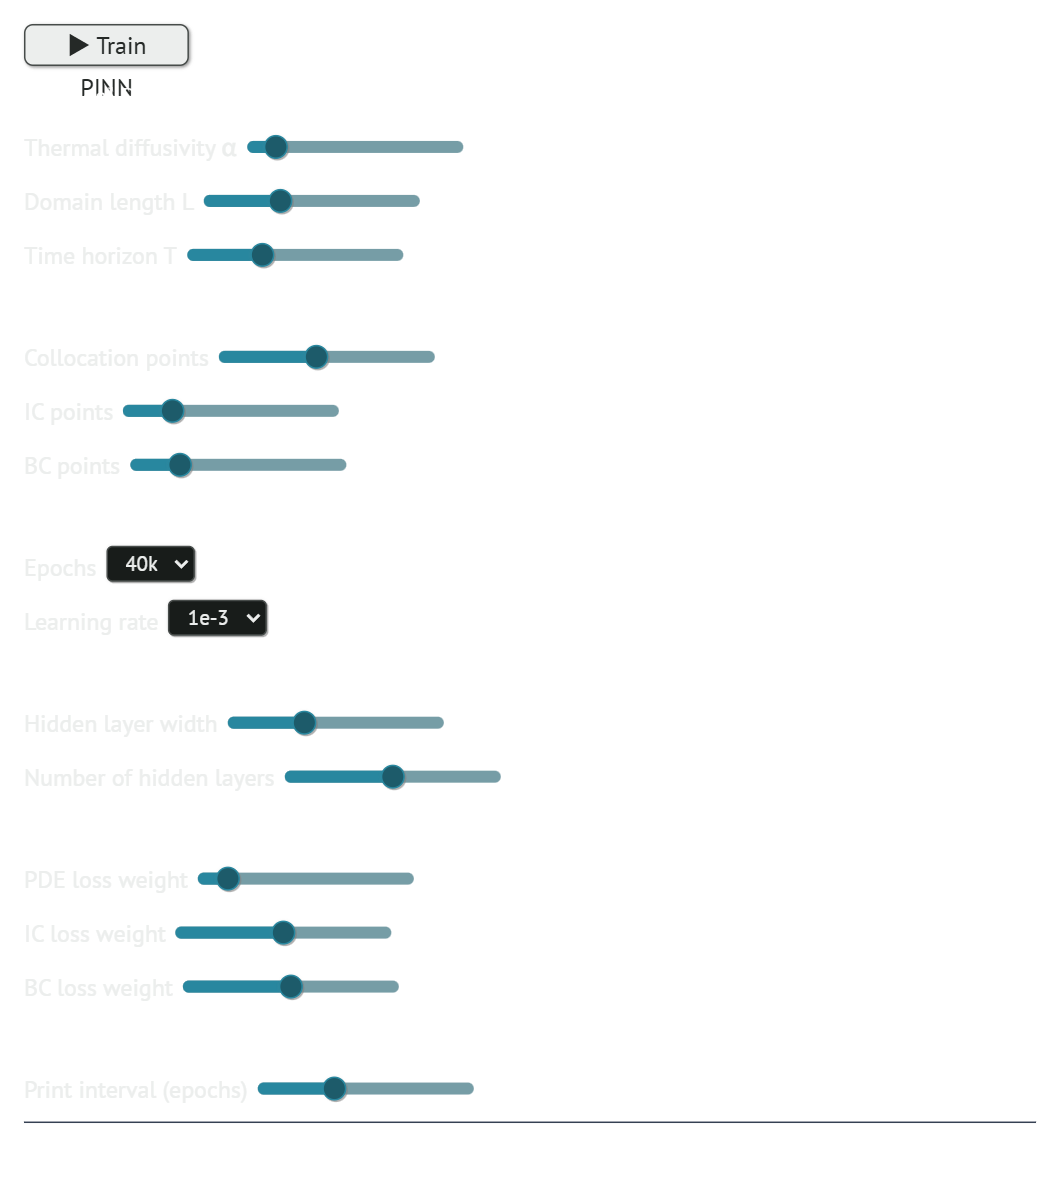

In [ ]:
# Physical parameters
alpha_slider = mo.ui.slider(
    0.001, 0.1, value=0.01, step=0.001, label="Thermal diffusivity α"
)
x_max_slider = mo.ui.slider(0.5, 2.0, value=1.0, step=0.1, label="Domain length L")
t_max_slider = mo.ui.slider(0.5, 2.0, value=1.0, step=0.1, label="Time horizon T")

# Training parameters
n_collocation_slider = mo.ui.slider(
    1000, 10000, value=5000, step=500, label="Collocation points"
)
n_ic_slider = mo.ui.slider(50, 300, value=100, step=10, label="IC points")
n_bc_slider = mo.ui.slider(50, 300, value=100, step=10, label="BC points")
epochs_dropdown = mo.ui.dropdown(
    {
        "5k": 5000,
        "10k": 10000,
        "20k": 20000,
        "40k": 40000,
        "60k": 60000,
    },
    value="40k",
    label="Epochs",
)
lr_dropdown = mo.ui.dropdown(
    {"1e-4": 1e-4, "5e-4": 5e-4, "1e-3": 1e-3, "2e-3": 2e-3},
    value="1e-3",
    label="Learning rate",
)

# Loss weights
pde_weight_slider = mo.ui.slider(
    0.1, 10.0, value=1.0, step=0.1, label="PDE loss weight"
)
ic_weight_slider = mo.ui.slider(
    0.1, 20.0, value=10.0, step=0.5, label="IC loss weight"
)
bc_weight_slider = mo.ui.slider(
    0.1, 20.0, value=10.0, step=0.5, label="BC loss weight"
)

# Network architecture
hidden_width_slider = mo.ui.slider(
    16, 64, value=32, step=8, label="Hidden layer width"
)
num_layers_slider = mo.ui.slider(
    1, 5, value=3, step=1, label="Number of hidden layers"
)

# Visualization
print_every_slider = mo.ui.slider(
    500, 5000, value=2000, step=500, label="Print interval (epochs)"
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

control_panel = mo.vstack([
    mo.md("#### Physical Parameters"),
    alpha_slider,
    x_max_slider,
    t_max_slider,
    mo.md("#### Domain Sampling"),
    n_collocation_slider,
    n_ic_slider,
    n_bc_slider,
    mo.md("#### Training Configuration"),
    epochs_dropdown,
    lr_dropdown,
    mo.md("#### Network Architecture"),
    hidden_width_slider,
    num_layers_slider,
    mo.md("#### Loss Weights"),
    pde_weight_slider,
    ic_weight_slider,
    bc_weight_slider,
    mo.md("#### Visualization"),
    print_every_slider,
    mo.md("---"),
    mo.md(f"**Device:** `{device}`"),
])

train_button = mo.ui.run_button(label="▶ Train PINN")

mo.vstack([train_button, control_panel])

In [ ]:
mo.stop(not train_button.value, mo.md("_Click **▶ Train PINN** to begin training_"))

results = train_model(
    x_min=0.0,
    x_max=x_max_slider.value,
    t_min=0.0,
    t_max=t_max_slider.value,
    alpha=alpha_slider.value,
    n_collocation=n_collocation_slider.value,
    n_ic=n_ic_slider.value,
    n_bc=n_bc_slider.value,
    epochs=epochs_dropdown.value,
    lr=lr_dropdown.value,
    pde_weight=pde_weight_slider.value,
    ic_weight=ic_weight_slider.value,
    bc_weight=bc_weight_slider.value,
    hidden_width=hidden_width_slider.value,
    num_layers=num_layers_slider.value,
    print_every=print_every_slider.value,
    device_type=device.type,
)

mo.md(f"✅ **Training complete!** Final total loss: {results['losses']['total'][-1]:.6e}")

/home/honghui/miniconda3/envs/sciml/lib/python3.13/site-packages/torch/autograd/graph.py:865: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:330.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [2000/40000], Total Loss: 0.000322, PDE: 0.000202, IC: 0.000007, BC: 0.000005
Epoch [4000/40000], Total Loss: 0.000111, PDE: 0.000076, IC: 0.000003, BC: 0.000001
Epoch [6000/40000], Total Loss: 0.000046, PDE: 0.000035, IC: 0.000001, BC: 0.000000
Epoch [8000/40000], Total Loss: 0.000668, PDE: 0.000022, IC: 0.000018, BC: 0.000047
Epoch [10000/40000], Total Loss: 0.000039, PDE: 0.000018, IC: 0.000001, BC: 0.000001
Epoch [12000/40000], Total Loss: 0.000112, PDE: 0.000015, IC: 0.000003, BC: 0.000007
Epoch [14000/40000], Total Loss: 0.000018, PDE: 0.000013, IC: 0.000000, BC: 0.000000
Epoch [16000/40000], Total Loss: 0.005944, PDE: 0.000011, IC: 0.000183, BC: 0.000411
Epoch [18000/40000], Total Loss: 0.000018, PDE: 0.000012, IC: 0.000000, BC: 0.000000
Epoch [20000/40000], Total Loss: 0.000020, PDE: 0.000011, IC: 0.000001, BC: 0.000000
Epoch [22000/40000], Total Loss: 0.000015, PDE: 0.000010, IC: 0.000000, BC: 0.000000
Epoch [24000/40000], Total Loss: 0.000014, PDE: 0.000010, IC: 0.00000

<span class="markdown prose dark:prose-invert contents"><span class="paragraph">✅ <strong>Training complete!</strong> Final total loss: 5.681575e-06</span></span>

---
## 4. Results Analysis

### 4.1 3D Surface Plot: PINN Solution

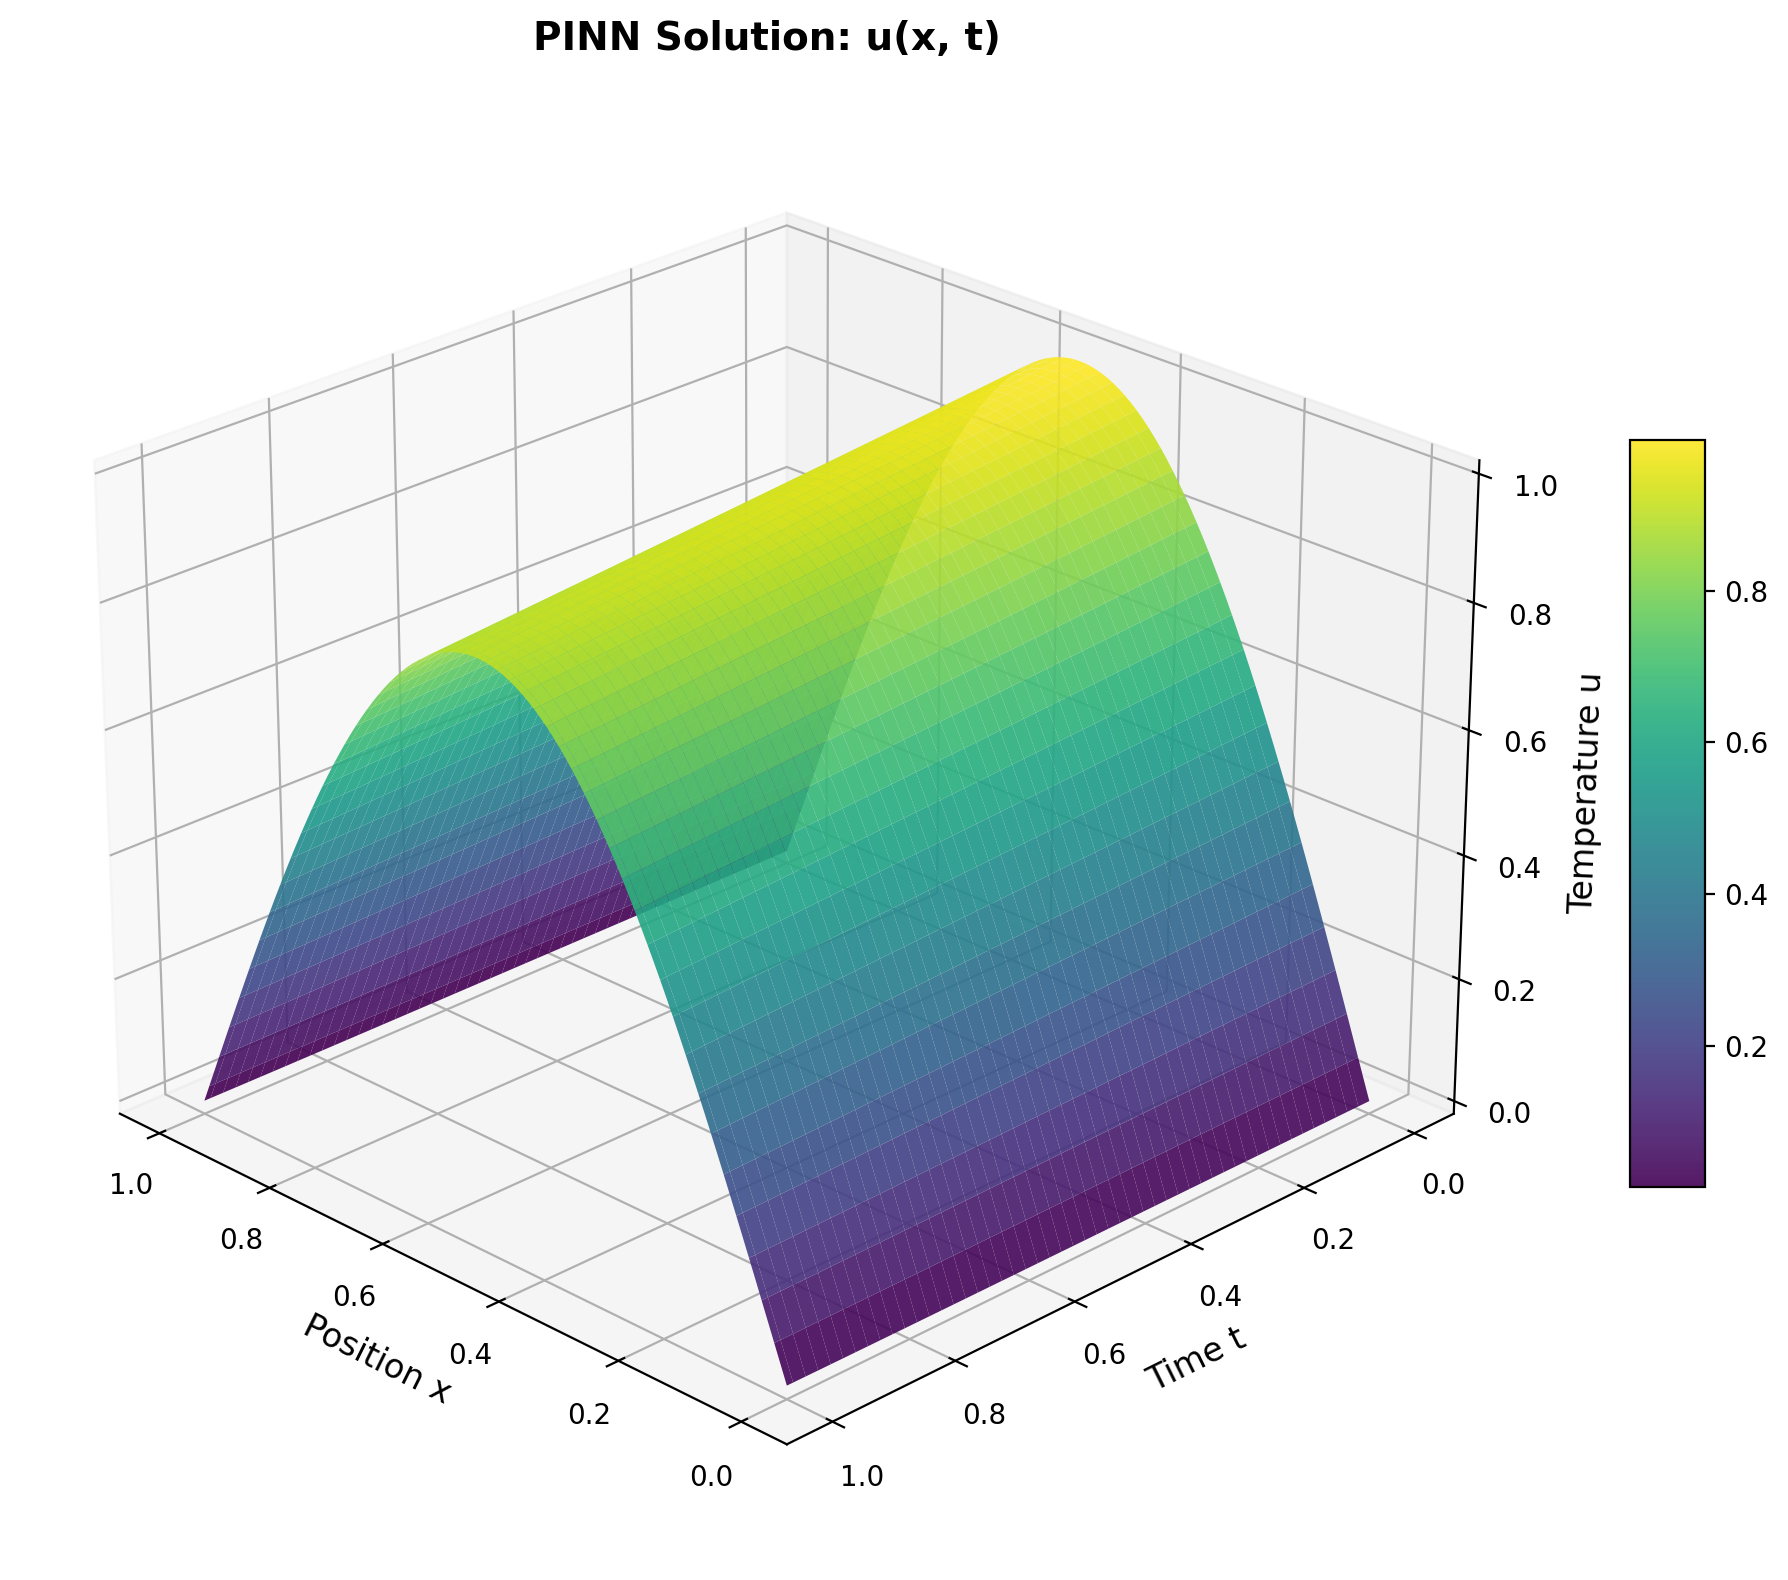

In [ ]:
fig_3d = plt.figure(figsize=(12, 8))
ax_3d = fig_3d.add_subplot(111, projection='3d')
surf = ax_3d.plot_surface(
    results['X_test'],
    results['T_test'],
    results['u_pred'],
    cmap=cm.viridis,
    linewidth=0,
    antialiased=True,
    alpha=0.9
)
ax_3d.set_title("PINN Solution: u(x, t)", fontsize=14, fontweight='bold')
ax_3d.set_xlabel("Position x", fontsize=12)
ax_3d.set_ylabel("Time t", fontsize=12)
ax_3d.set_zlabel("Temperature u", fontsize=12)
ax_3d.view_init(elev=25, azim=135)
fig_3d.colorbar(surf, ax=ax_3d, shrink=0.5, aspect=10)
plt.tight_layout()
fig_3d

### 4.2 Comparison with Analytical Solution

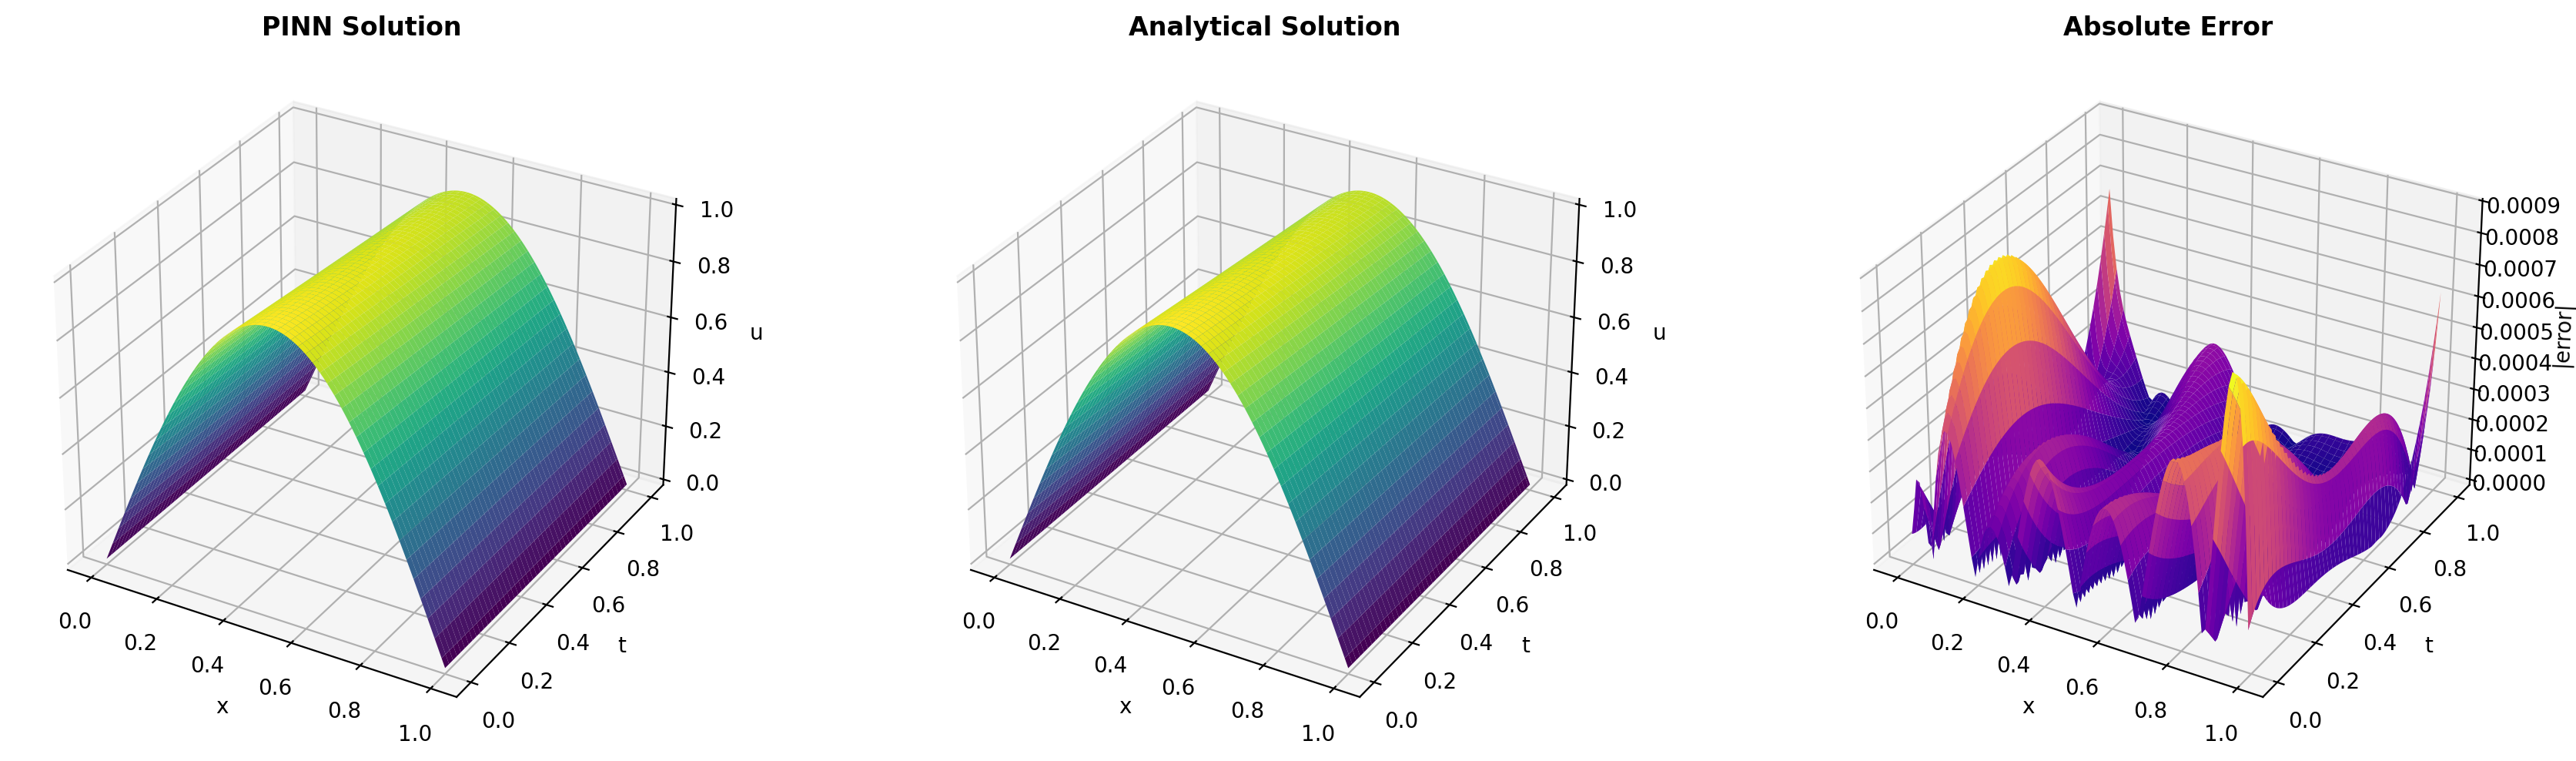

In [ ]:
fig_compare = plt.figure(figsize=(18, 5))

# PINN Solution
ax1 = fig_compare.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(
    results['X_test'],
    results['T_test'],
    results['u_pred'],
    cmap=cm.viridis,
    linewidth=0,
    antialiased=True
)
ax1.set_title("PINN Solution", fontsize=12, fontweight='bold')
ax1.set_xlabel("x")
ax1.set_ylabel("t")
ax1.set_zlabel("u")

# Analytical Solution
ax2 = fig_compare.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(
    results['X_test'],
    results['T_test'],
    results['u_analytical'],
    cmap=cm.viridis,
    linewidth=0,
    antialiased=True
)
ax2.set_title("Analytical Solution", fontsize=12, fontweight='bold')
ax2.set_xlabel("x")
ax2.set_ylabel("t")
ax2.set_zlabel("u")

# Error
error = np.abs(results['u_pred'] - results['u_analytical'])
ax3 = fig_compare.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(
    results['X_test'],
    results['T_test'],
    error,
    cmap=cm.plasma,
    linewidth=0,
    antialiased=True
)
ax3.set_title("Absolute Error", fontsize=12, fontweight='bold')
ax3.set_xlabel("x")
ax3.set_ylabel("t")
ax3.set_zlabel("|error|")

plt.tight_layout()
fig_compare

### 4.3 2D Heatmap Visualization

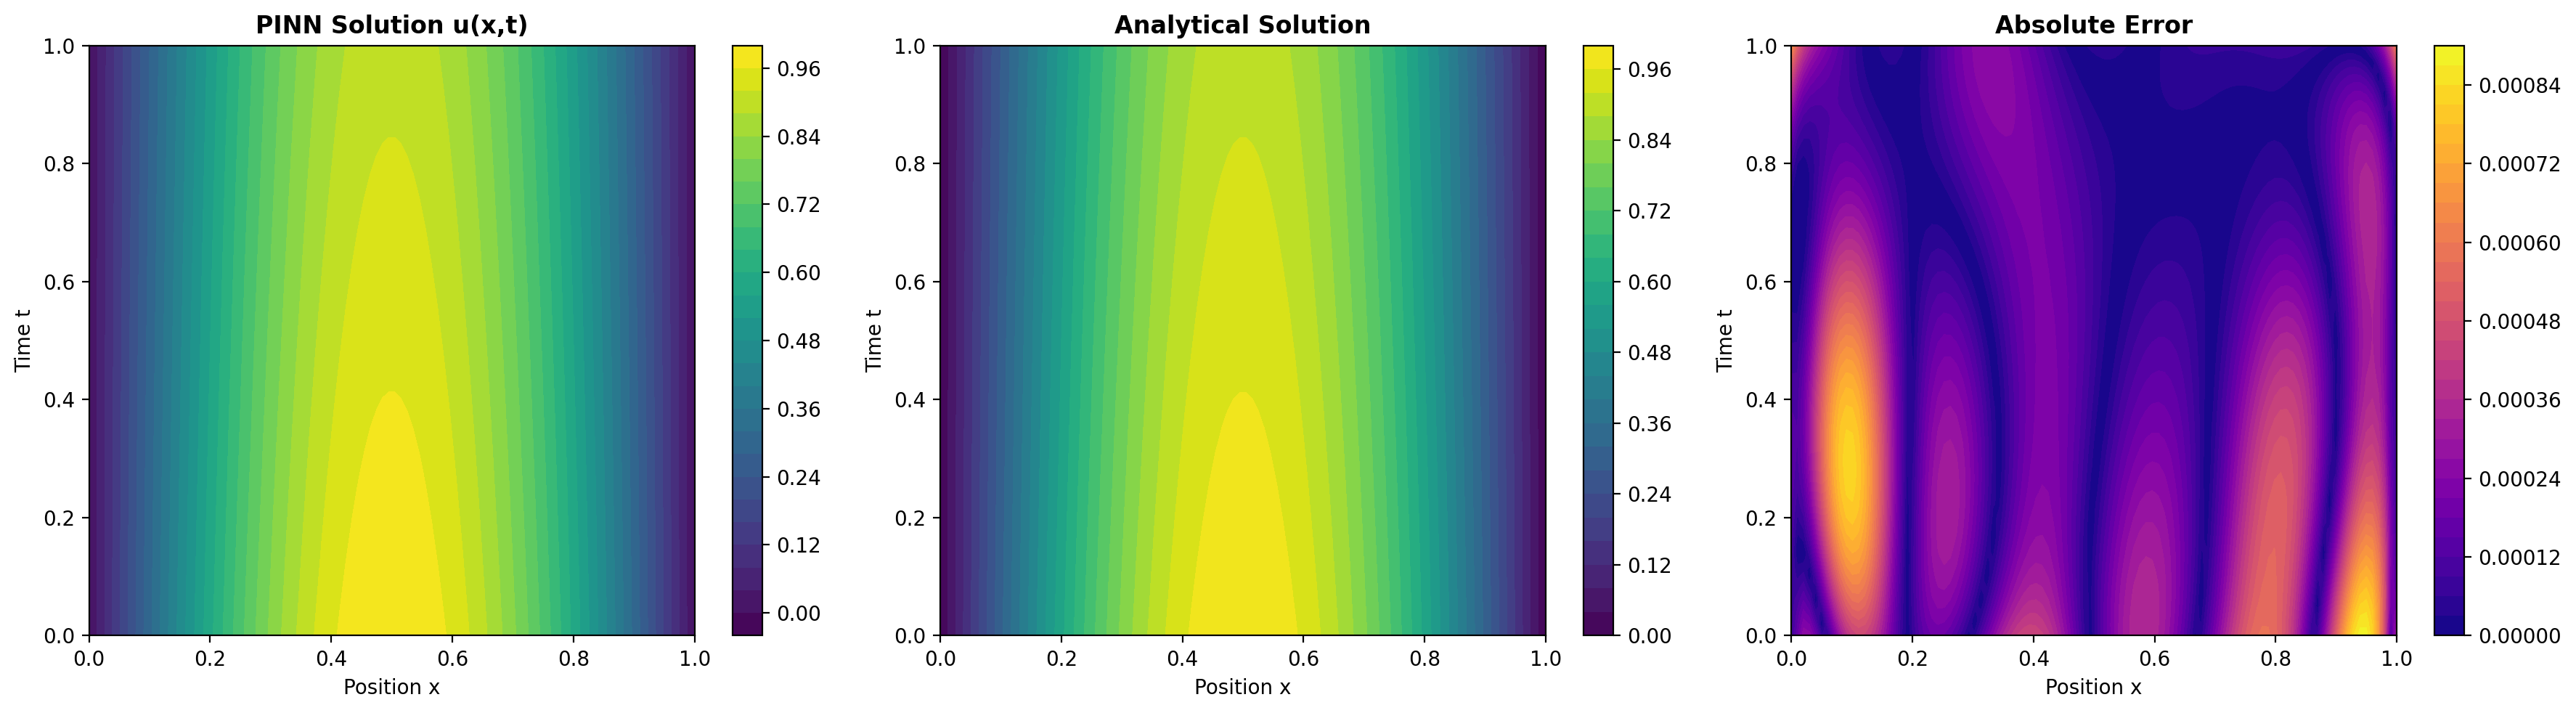

In [ ]:
fig_heatmap, axes = plt.subplots(1, 3, figsize=(18, 5))

# PINN Solution
im1 = axes[0].contourf(
    results['X_test'],
    results['T_test'],
    results['u_pred'],
    levels=30,
    cmap='viridis'
)
axes[0].set_title("PINN Solution u(x,t)", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Position x")
axes[0].set_ylabel("Time t")
plt.colorbar(im1, ax=axes[0])

# Analytical Solution
im2 = axes[1].contourf(
    results['X_test'],
    results['T_test'],
    results['u_analytical'],
    levels=30,
    cmap='viridis'
)
axes[1].set_title("Analytical Solution", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Position x")
axes[1].set_ylabel("Time t")
plt.colorbar(im2, ax=axes[1])

# Error
im3 = axes[2].contourf(
    results['X_test'],
    results['T_test'],
    error,
    levels=30,
    cmap='plasma'
)
axes[2].set_title("Absolute Error", fontsize=12, fontweight='bold')
axes[2].set_xlabel("Position x")
axes[2].set_ylabel("Time t")
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
fig_heatmap

### 4.4 Temporal Slices: u(x) at Different Times

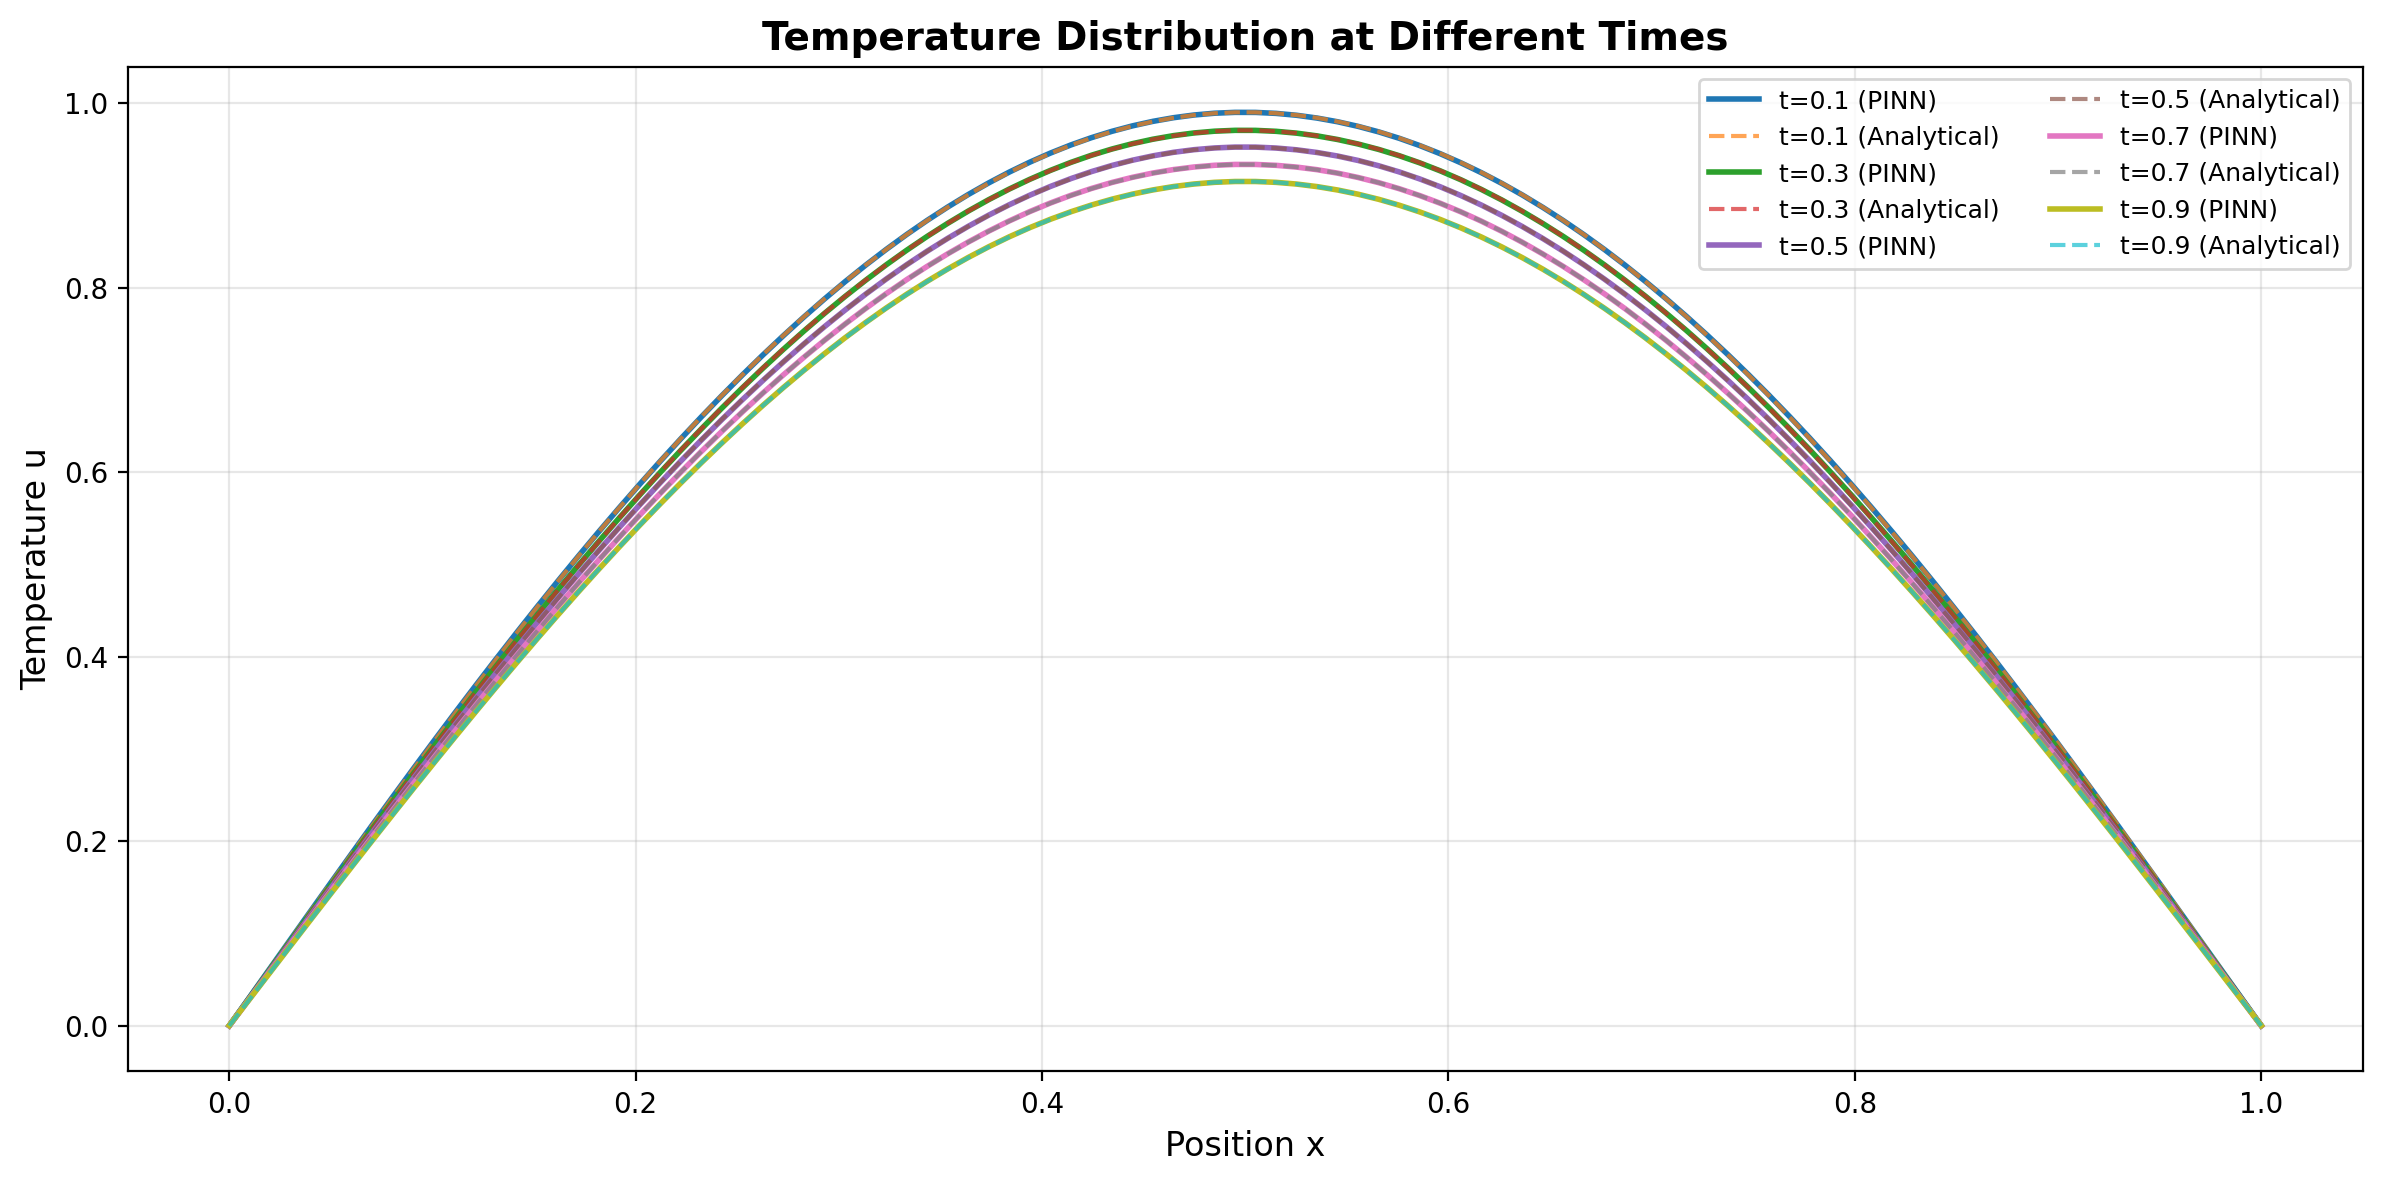

In [ ]:
fig_time_slices, ax_time = plt.subplots(figsize=(12, 6))

# Select 5 time slices
t_slices = [0.1, 0.3, 0.5, 0.7, 0.9]
t_max_val = results['t_test'].max()

for t_val in t_slices:
    if t_val <= t_max_val:
        # Find closest time index
        t_idx = np.argmin(np.abs(results['t_test'] - t_val))

        # PINN solution
        ax_time.plot(
            results['x_test'],
            results['u_pred'][t_idx, :],
            label=f't={t_val:.1f} (PINN)',
            linewidth=2
        )

        # Analytical solution
        ax_time.plot(
            results['x_test'],
            results['u_analytical'][t_idx, :],
            '--',
            label=f't={t_val:.1f} (Analytical)',
            alpha=0.7
        )

ax_time.set_xlabel("Position x", fontsize=12)
ax_time.set_ylabel("Temperature u", fontsize=12)
ax_time.set_title("Temperature Distribution at Different Times", fontsize=14, fontweight='bold')
ax_time.legend(ncol=2, fontsize=9)
ax_time.grid(True, alpha=0.3)
plt.tight_layout()
fig_time_slices

### 4.5 Spatial Slices: u(t) at Different Positions

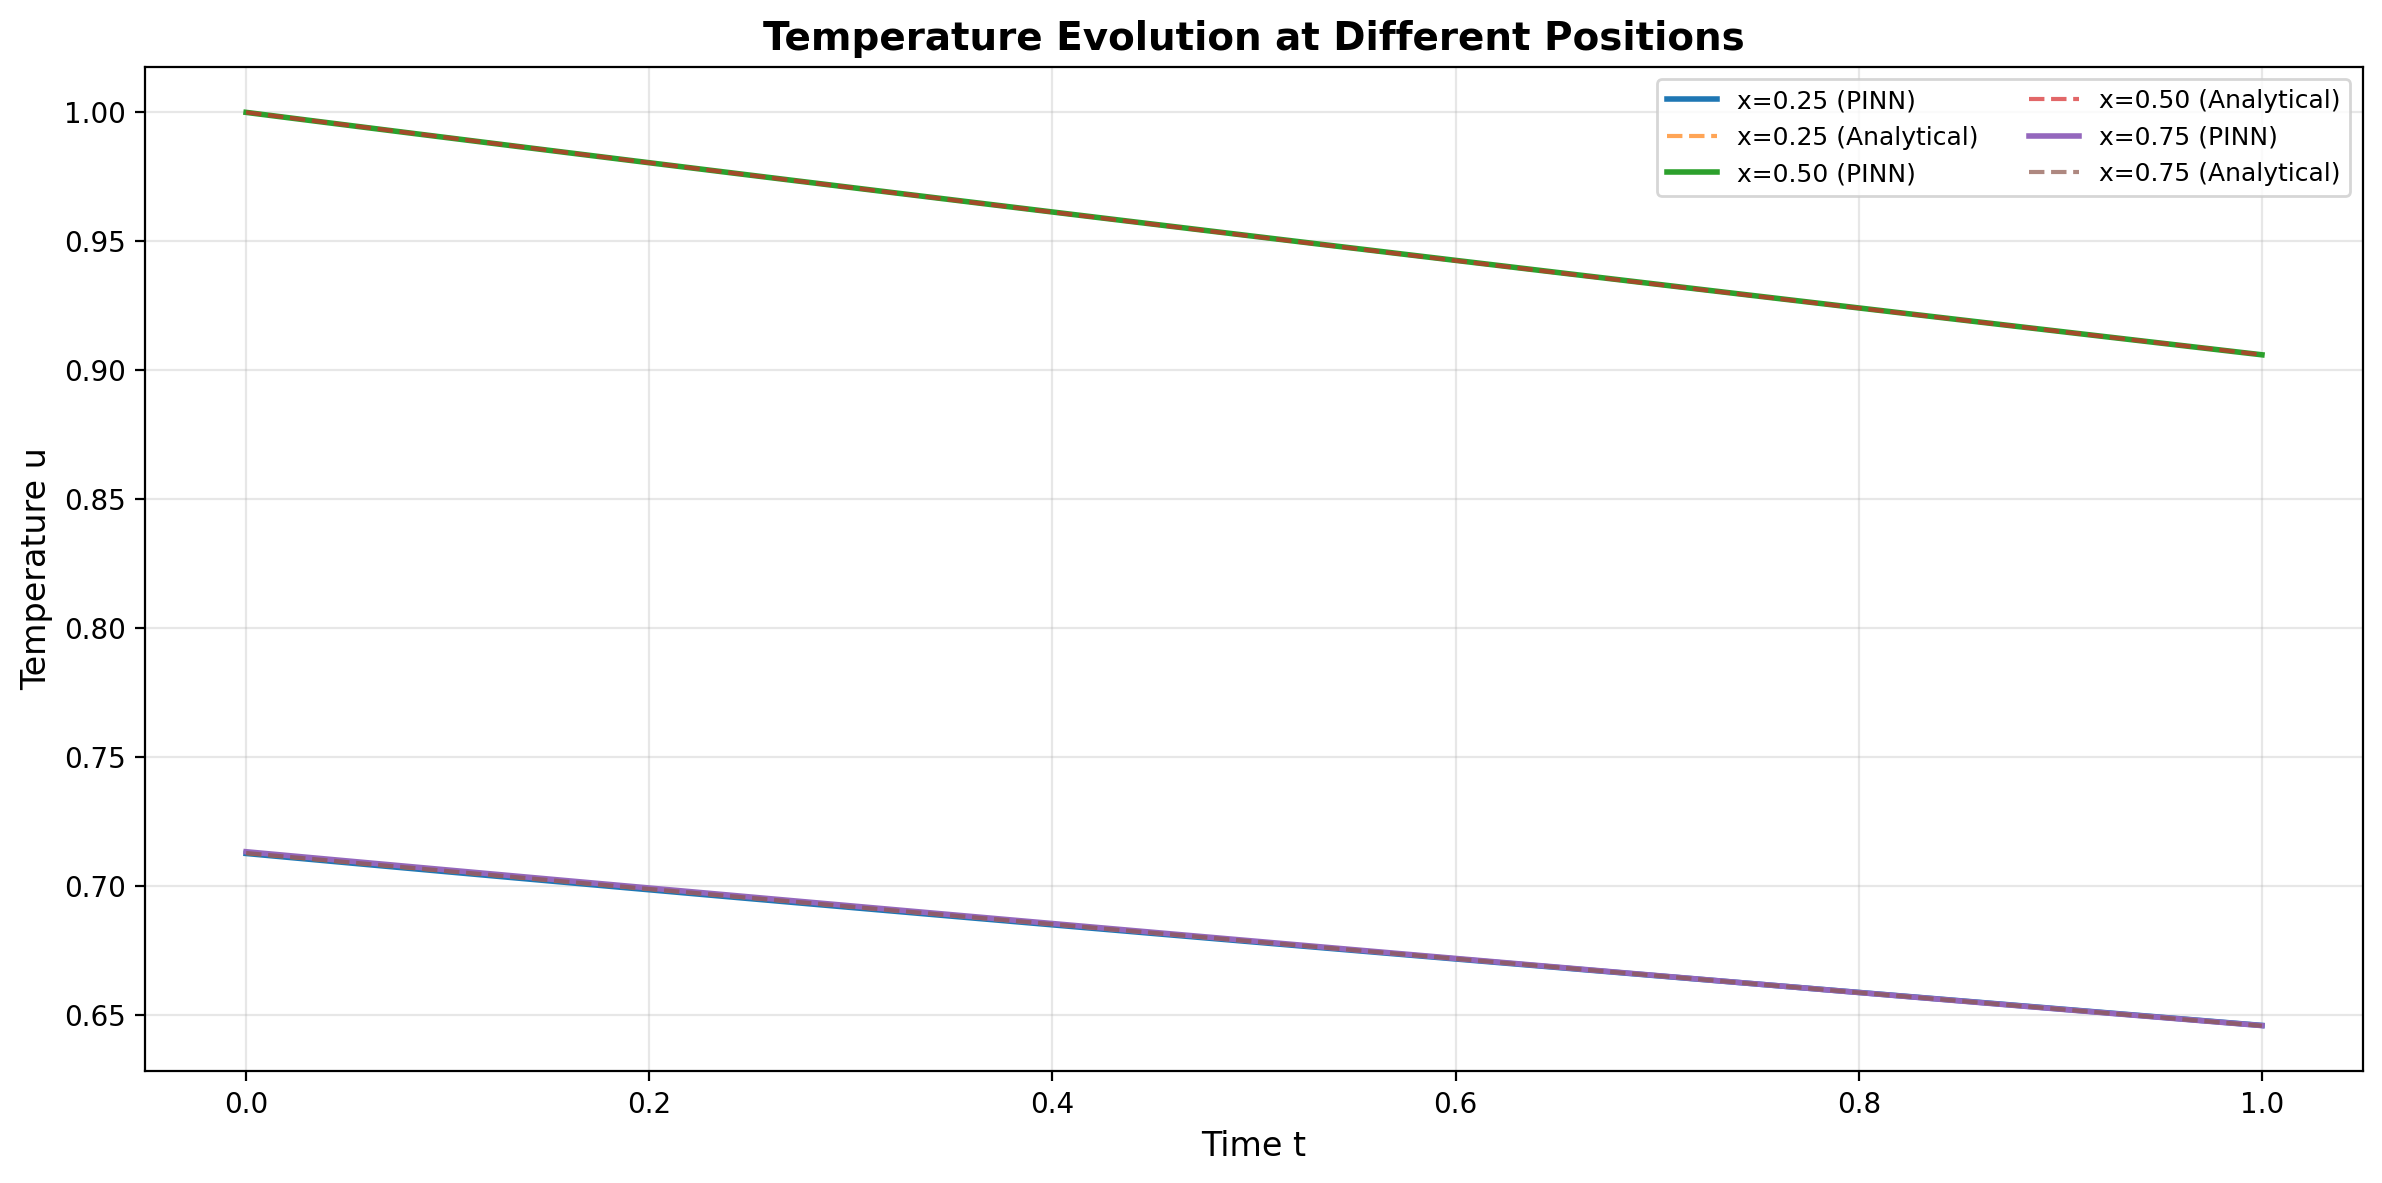

In [ ]:
fig_space_slices, ax_space = plt.subplots(figsize=(12, 6))

# Select 5 spatial positions
x_max_val = results['x_test'].max()
x_slices = [0.25 * x_max_val, 0.5 * x_max_val, 0.75 * x_max_val]

for x_val in x_slices:
    # Find closest position index
    x_idx = np.argmin(np.abs(results['x_test'] - x_val))

    # PINN solution
    ax_space.plot(
        results['t_test'],
        results['u_pred'][:, x_idx],
        label=f'x={x_val:.2f} (PINN)',
        linewidth=2
    )

    # Analytical solution
    ax_space.plot(
        results['t_test'],
        results['u_analytical'][:, x_idx],
        '--',
        label=f'x={x_val:.2f} (Analytical)',
        alpha=0.7
    )

ax_space.set_xlabel("Time t", fontsize=12)
ax_space.set_ylabel("Temperature u", fontsize=12)
ax_space.set_title("Temperature Evolution at Different Positions", fontsize=14, fontweight='bold')
ax_space.legend(ncol=2, fontsize=9)
ax_space.grid(True, alpha=0.3)
plt.tight_layout()
fig_space_slices

### 4.6 Physics Residual Validation

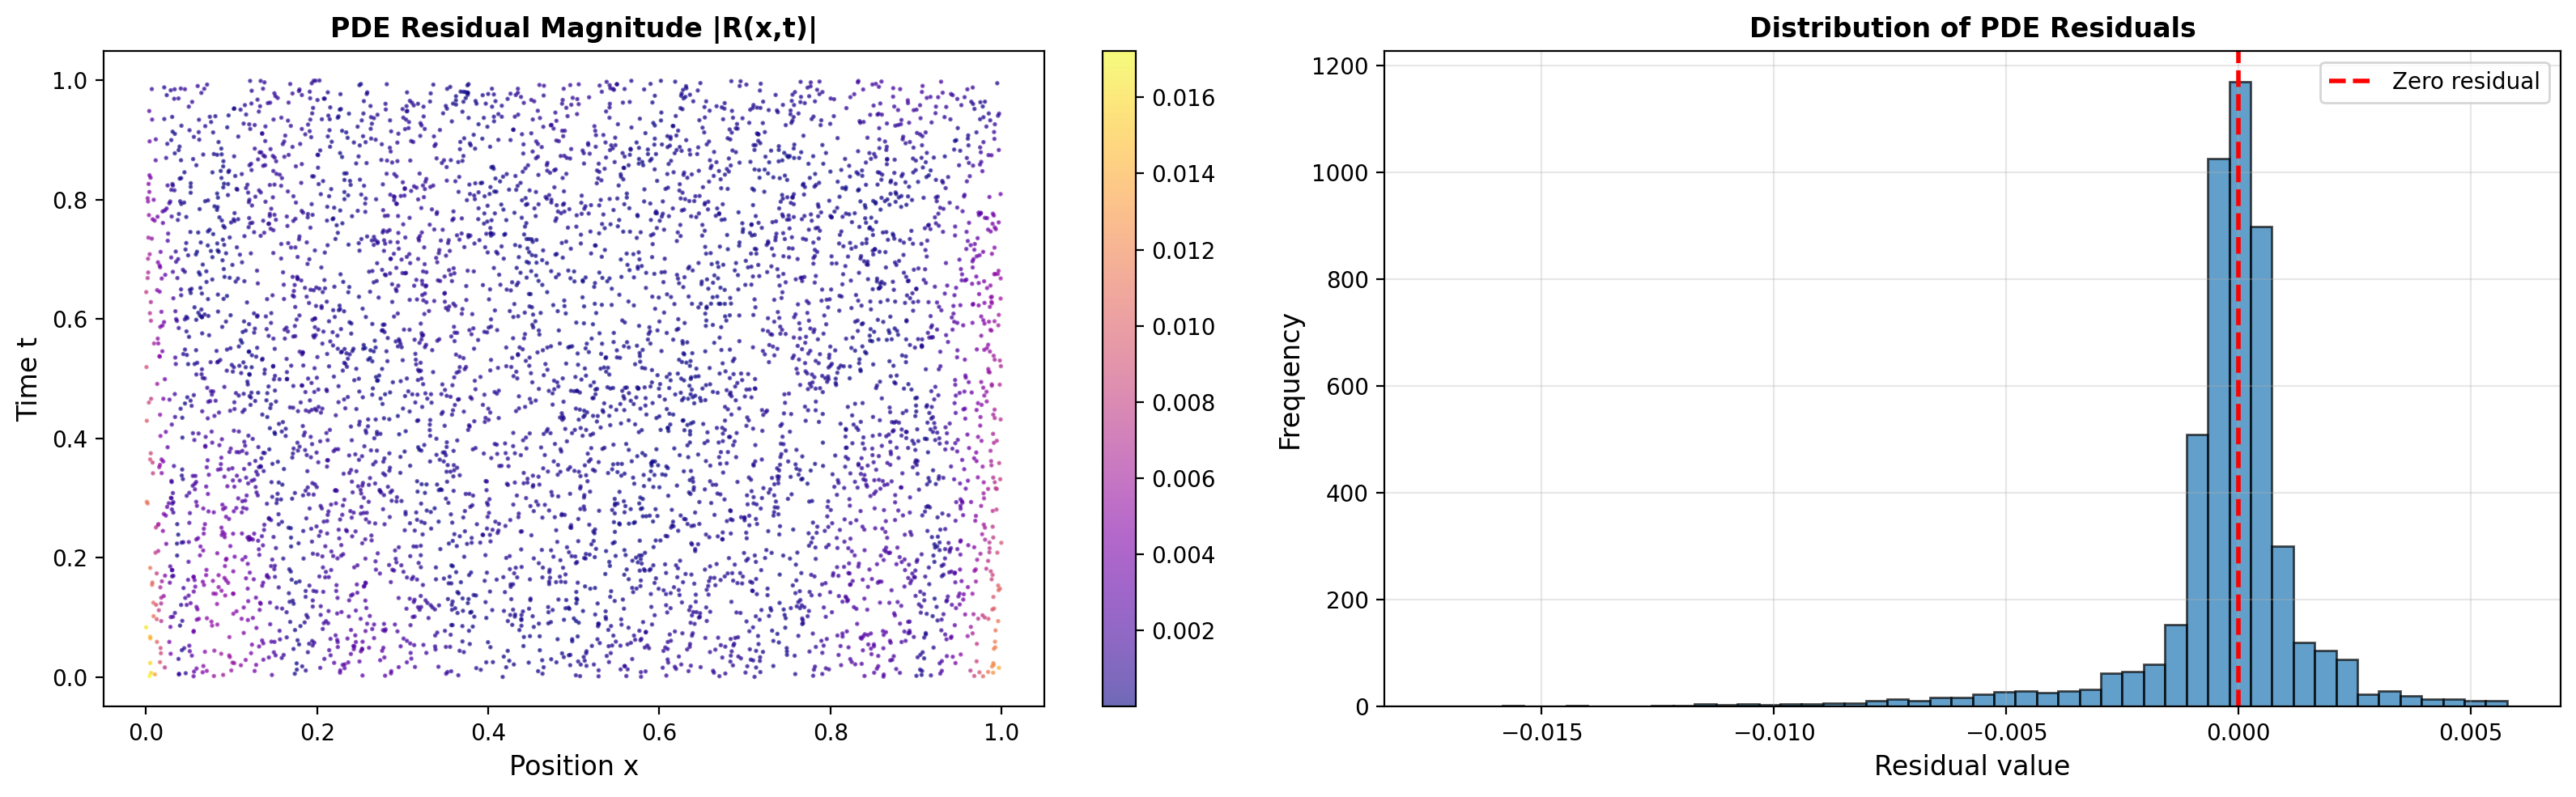

In [ ]:
fig_residual, axes_res = plt.subplots(1, 2, figsize=(16, 5))

# Scatter plot of residuals
residuals_flat = results['pde_residuals'].flatten()
x_col = results['collocation_points'][:, 0]
t_col = results['collocation_points'][:, 1]

sc = axes_res[0].scatter(
    x_col,
    t_col,
    c=np.abs(residuals_flat),
    cmap='plasma',
    s=1,
    alpha=0.6
)
axes_res[0].set_xlabel("Position x", fontsize=12)
axes_res[0].set_ylabel("Time t", fontsize=12)
axes_res[0].set_title("PDE Residual Magnitude |R(x,t)|", fontsize=12, fontweight='bold')
plt.colorbar(sc, ax=axes_res[0])

# Histogram of residuals
axes_res[1].hist(residuals_flat, bins=50, edgecolor='black', alpha=0.7)
axes_res[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero residual')
axes_res[1].set_xlabel("Residual value", fontsize=12)
axes_res[1].set_ylabel("Frequency", fontsize=12)
axes_res[1].set_title("Distribution of PDE Residuals", fontsize=12, fontweight='bold')
axes_res[1].legend()
axes_res[1].grid(True, alpha=0.3)

plt.tight_layout()

residual_stats = f"""
**Residual Statistics:**
- Mean: {np.mean(residuals_flat):.6e}
- Std: {np.std(residuals_flat):.6e}
- Max: {np.max(np.abs(residuals_flat)):.6e}
- L2 norm: {np.linalg.norm(residuals_flat):.6e}
"""

fig_residual

In [ ]:
mo.md(residual_stats)

<span class="markdown prose dark:prose-invert contents"><span class="paragraph"><strong>Residual Statistics:</strong></span>
<ul>
<li>Mean: -3.045451e-04</li>
<li>Std: 1.900637e-03</li>
<li>Max: 1.722196e-02</li>
<li>L2 norm: 1.361097e-01</li>
</ul></span>

### 4.7 Training Dynamics

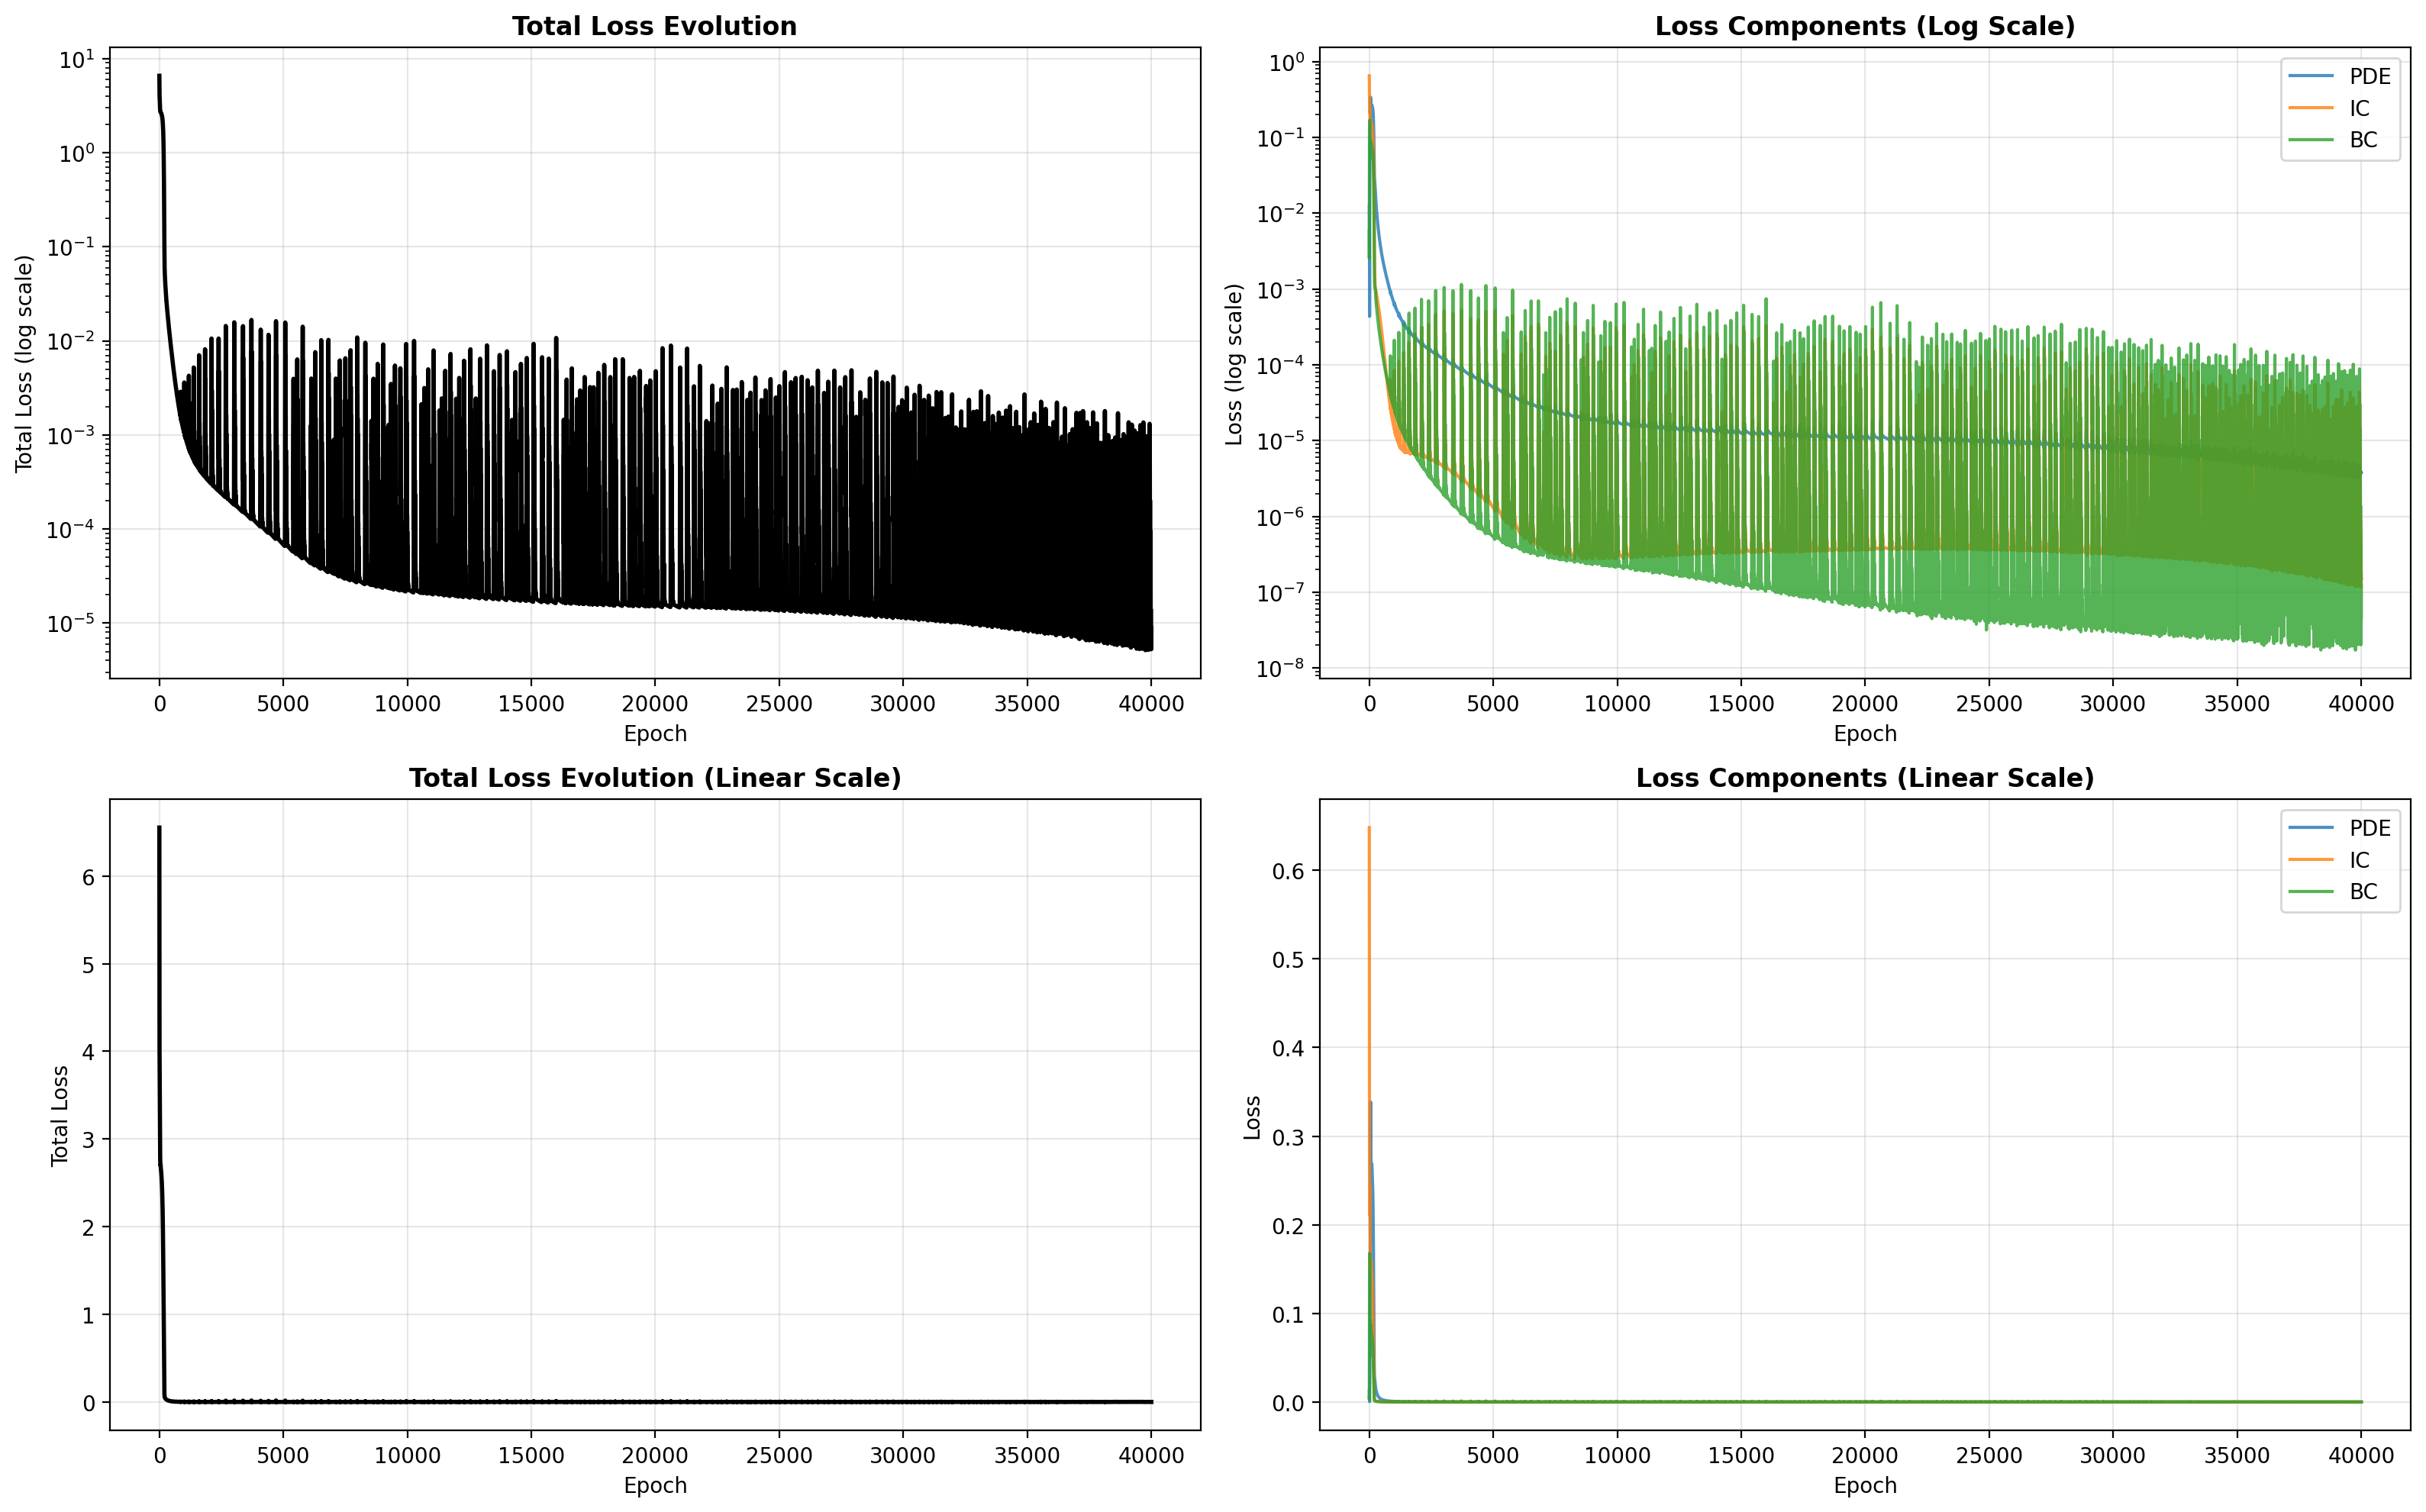

In [ ]:
fig_training, axes_train = plt.subplots(2, 2, figsize=(16, 10))

epochs_array = np.arange(1, len(results['losses']['total']) + 1)

# Total loss (log scale)
axes_train[0, 0].semilogy(epochs_array, results['losses']['total'], linewidth=2, color='black')
axes_train[0, 0].set_xlabel("Epoch")
axes_train[0, 0].set_ylabel("Total Loss (log scale)")
axes_train[0, 0].set_title("Total Loss Evolution", fontweight='bold')
axes_train[0, 0].grid(True, alpha=0.3)

# Individual losses (log scale)
axes_train[0, 1].semilogy(epochs_array, results['losses']['pde'], label='PDE', alpha=0.8)
axes_train[0, 1].semilogy(epochs_array, results['losses']['ic'], label='IC', alpha=0.8)
axes_train[0, 1].semilogy(epochs_array, results['losses']['bc'], label='BC', alpha=0.8)
axes_train[0, 1].set_xlabel("Epoch")
axes_train[0, 1].set_ylabel("Loss (log scale)")
axes_train[0, 1].set_title("Loss Components (Log Scale)", fontweight='bold')
axes_train[0, 1].legend()
axes_train[0, 1].grid(True, alpha=0.3)

# Total loss (linear scale)
axes_train[1, 0].plot(epochs_array, results['losses']['total'], linewidth=2, color='black')
axes_train[1, 0].set_xlabel("Epoch")
axes_train[1, 0].set_ylabel("Total Loss")
axes_train[1, 0].set_title("Total Loss Evolution (Linear Scale)", fontweight='bold')
axes_train[1, 0].grid(True, alpha=0.3)

# Individual losses (linear scale)
axes_train[1, 1].plot(epochs_array, results['losses']['pde'], label='PDE', alpha=0.8)
axes_train[1, 1].plot(epochs_array, results['losses']['ic'], label='IC', alpha=0.8)
axes_train[1, 1].plot(epochs_array, results['losses']['bc'], label='BC', alpha=0.8)
axes_train[1, 1].set_xlabel("Epoch")
axes_train[1, 1].set_ylabel("Loss")
axes_train[1, 1].set_title("Loss Components (Linear Scale)", fontweight='bold')
axes_train[1, 1].legend()
axes_train[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
fig_training

### 4.8 Error Metrics Summary

In [ ]:
mae = np.mean(error)
rmse = np.sqrt(np.mean(error**2))
max_error = np.max(error)
residual_l2 = np.linalg.norm(residuals_flat)

error_data = [
    ["Mean Absolute Error (MAE)", f"{mae:.6e}"],
    ["Root Mean Square Error (RMSE)", f"{rmse:.6e}"],
    ["Maximum Error", f"{max_error:.6e}"],
    ["PDE Residual L2 Norm", f"{residual_l2:.6e}"],
]

In [ ]:
mo.md(f"""
| Metric | Value |
|--------|-------|
{chr(10).join(f"| {row[0]} | {row[1]} |" for row in error_data)}
""")

<span class="markdown prose dark:prose-invert contents"><table>
<thead>
<tr>
<th>Metric</th>
<th>Value</th>
</tr>
</thead>
<tbody>
<tr>
<td>Mean Absolute Error (MAE)</td>
<td>1.923748e-04</td>
</tr>
<tr>
<td>Root Mean Square Error (RMSE)</td>
<td>2.584377e-04</td>
</tr>
<tr>
<td>Maximum Error</td>
<td>8.879009e-04</td>
</tr>
<tr>
<td>PDE Residual L2 Norm</td>
<td>1.361097e-01</td>
</tr>
</tbody>
</table></span>

## Summary

### Key Features of this PINN Implementation

✅ **Multi-term Loss Function**
- PDE residual enforces heat equation at collocation points
- Initial condition loss ensures correct starting temperature distribution
- Boundary condition losses maintain fixed boundary temperatures

✅ **Automatic Differentiation**
- First-order derivatives: $\frac{\partial u}{\partial x}$, $\frac{\partial u}{\partial t}$
- Second-order derivative: $\frac{\partial^2 u}{\partial x^2}$
- Computed using PyTorch's autograd with `create_graph=True`

✅ **Validation Against Analytical Solution**
- Exact solution: $u(x,t) = \sin(\pi x) e^{-\pi^2 \alpha t}$
- Provides ground truth for error analysis

### Strengths

- **No mesh required**: Unlike finite difference/element methods
- **Smooth solutions**: Neural network provides continuous interpolation
- **Physics-informed**: Satisfies governing equations during training

### Limitations

- **Computational cost**: Training can be slow for complex PDEs
- **Hyperparameter sensitivity**: Loss weights affect convergence
- **Local minima**: May require multiple training runs

### Extensions

- 2D/3D heat equations
- Time-dependent boundary conditions
- Nonlinear PDEs (reaction-diffusion, Burgers' equation)
- Inverse problems (learning unknown parameters)